In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import sqlite3
import json
from datetime import datetime

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [4]:
from scipy.stats import spearmanr

## Read in data

read in station name

In [5]:
df = pd.read_json('../ML_data.json')

## clean data

In [6]:
dataset = df[['STN','ST','DATETIME','H','Temp','P','Vm','Vmsat']]

df_index = (dataset['DATETIME']>datetime(2015,1,1,0)) & (dataset['DATETIME']<datetime(2020,1,1,0))
dataset = dataset[df_index]

#stnlist=['新竹浮標','龜山島浮標','臺東外洋浮標','龍洞浮標','小琉球浮標','花蓮浮標','東沙島浮標','馬祖浮標']
#stnlist=['東沙島浮標']
#stnlist=['新竹浮標','臺東外洋浮標','東沙島浮標','馬祖浮標']
stnlist=['臺東外洋浮標','東沙島浮標','馬祖浮標']

dataset = dataset[dataset['STN'].isin(stnlist)]
dataset = dataset.dropna()

<Figure size 3200x1600 with 0 Axes>

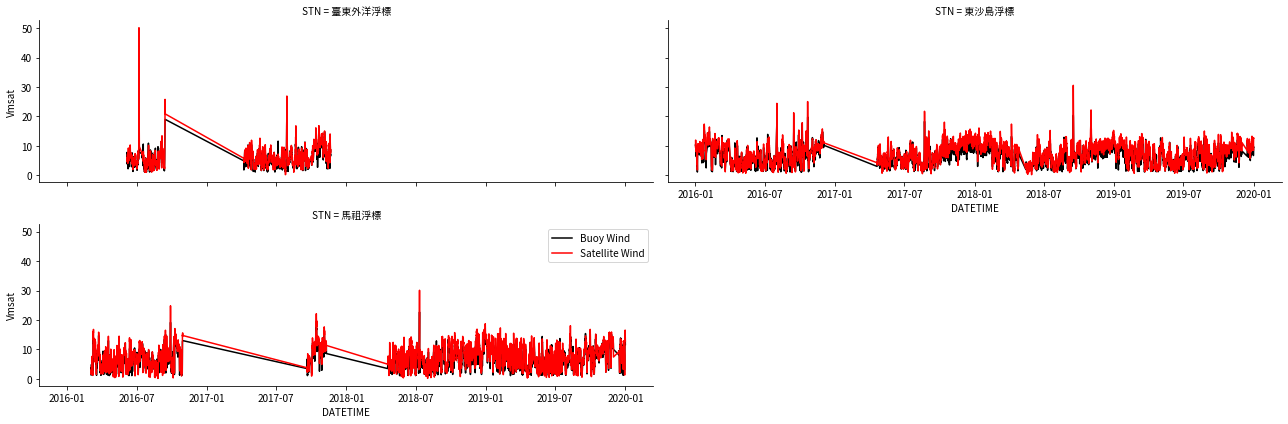

In [7]:
plt.figure(figsize=(16,8),dpi=200)
g = sns.FacetGrid(dataset, col="STN", col_wrap=2, height=3, aspect=3)
g.map(sns.lineplot, 'DATETIME','Vm',color='k')
g.map(sns.lineplot, 'DATETIME','Vmsat',color='r')
plt.legend(labels=['Buoy Wind','Satellite Wind'])

In [8]:
dataset.pop('DATETIME')
dataset.pop('ST')
dataset.pop('STN')

149823    臺東外洋浮標
149829    臺東外洋浮標
149835    臺東外洋浮標
149841    臺東外洋浮標
149847    臺東外洋浮標
           ...  
877101      馬祖浮標
877107      馬祖浮標
877113      馬祖浮標
877119      馬祖浮標
877125      馬祖浮標
Name: STN, Length: 9078, dtype: object

In [9]:
dataset.isna().sum()

H        0
Temp     0
P        0
Vm       0
Vmsat    0
dtype: int64

Drop those rows to keep this initial tutorial simple.

In [10]:
dataset = dataset.dropna()
dataset.isna().sum()

H        0
Temp     0
P        0
Vm       0
Vmsat    0
dtype: int64

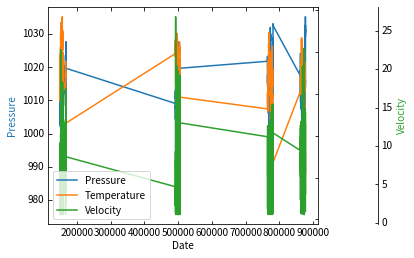

In [11]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 60
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2,
                                        offset=(offset, 0))

par2.axis["right"].toggle(all=True)


host.set_xlabel("Date")
host.set_ylabel("Pressure")
par1.set_ylabel("Temperature")
par2.set_ylabel("Velocity")

p1, = host.plot(dataset['P'], label="Pressure")
p2, = par1.plot(dataset['Temp'], label="Temperature")
p3, = par2.plot(dataset['Vm'], label="Velocity")

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())

host.legend()

### Split the data into train and test

Now split the dataset into a training set and a test set.

Use the test set in the final evaluation of your models.

In [12]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

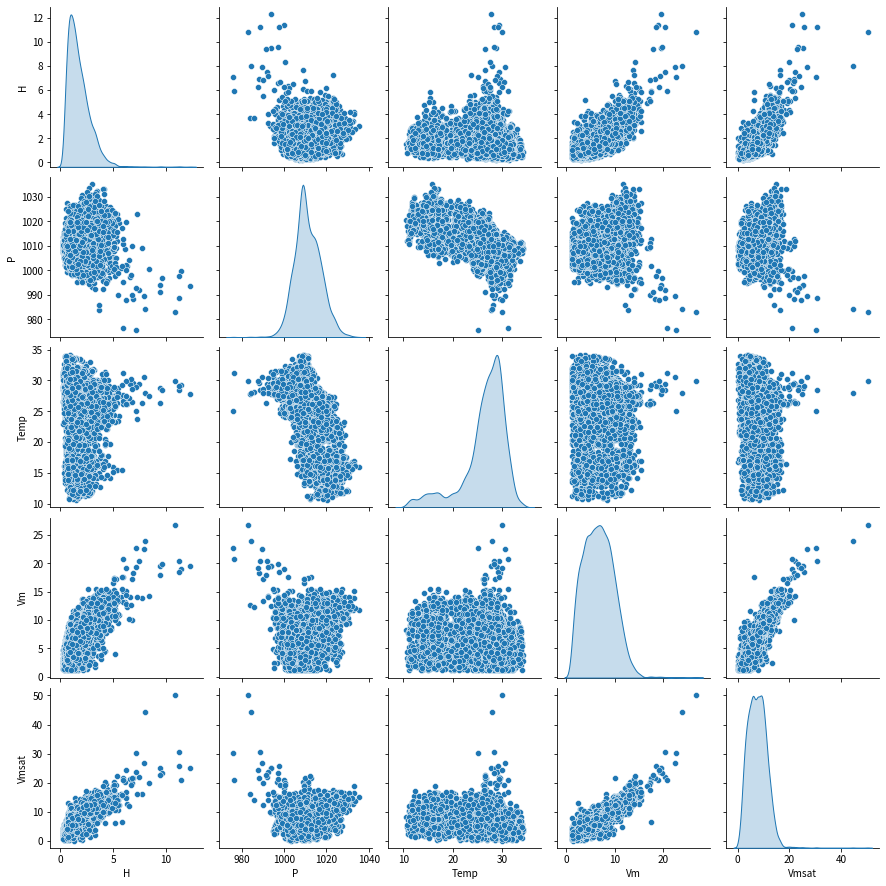

In [13]:
sns.pairplot(train_dataset[['H', 'P', 'Temp', 'Vm','Vmsat']], diag_kind='kde')

Also look at the overall statistics, note how each feature covers a very different range:

In [14]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
H,7262.0,1.747535,1.047002,0.240000,0.970000,1.510000,2.280000,12.300000
Temp,7262.0,26.327279,4.359655,10.600000,25.000000,27.300000,29.200000,34.200000
P,7262.0,1011.084426,6.154957,975.700000,1007.100000,1010.400000,1015.200000,1035.200000
Vm,7262.0,6.649766,3.067025,1.100000,4.200000,6.500000,8.800000,26.800000
Vmsat,7262.0,7.535785,3.547133,0.143646,4.826973,7.420243,9.935997,50.117094


### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [15]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Vm')
test_labels = test_features.pop('Vm')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [16]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
H,1.747535,1.047002
Temp,26.327279,4.359655
P,1011.084426,6.154957
Vm,6.649766,3.067025
Vmsat,7.535785,3.547133


It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable.

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [17]:
normalizer = preprocessing.Normalization(axis=-1)

Then `.adapt()` it to the data:

In [18]:
normalizer.adapt(np.array(train_features))

This calculates the mean and variance, and stores them in the layer. 

In [19]:
print(normalizer.mean.numpy())

[   1.748   26.327 1011.084    7.536]


When the layer is called it returns the input data, with each feature independently normalized:

In [20]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   1.34   28.2  1012.1     7.34]]

Normalized: [[-0.39  0.43  0.17 -0.05]]


## Linear regression

Before building a DNN model, start with a linear regression.

### One Variable

Start with a single-variable linear regression, to predict `H` from `Vmsat`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

* Normalize the input `Vmsat`.
* Apply a linear transformation ($y = mx+b$) to produce 1 output using `layers.Dense`.

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First create the horsepower `Normalization` layer:

In [21]:
Vmsat = np.array(train_features['Vmsat'])

Vmsat_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
Vmsat_normalizer.adapt(Vmsat)

Build the sequential model:

In [22]:
Vmsat_model = tf.keras.Sequential([
    Vmsat_normalizer,
    layers.Dense(units=1)
])

Vmsat_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `H` from `Vmsat`.

Run the untrained model on the first 10 Vmsat values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [23]:
Vmsat_model.predict(Vmsat[:10])

array([[-0.007],
       [ 0.085],
       [-0.17 ],
       [-0.04 ],
       [ 0.037],
       [-0.008],
       [ 0.088],
       [ 0.231],
       [ 0.01 ],
       [-0.027]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [24]:
Vmsat_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Once the training is configured, use `Model.fit()` to execute the training:

In [25]:
%%time
history = Vmsat_model.fit(
    train_features['Vmsat'], train_labels,
    epochs=100,
    batch_size=16,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 2min 38s, sys: 19min 13s, total: 21min 51s
Wall time: 37.4 s


Visualize the model's training progress using the stats stored in the `history` object.

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.923346,0.916479,95
96,0.921358,0.922233,96
97,0.918037,0.914874,97
98,0.922516,0.896948,98
99,0.915307,0.913848,99


In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 3])
  plt.xlabel('Epoch')
  plt.ylabel('Error [H]')
  plt.legend()
  plt.grid(True)

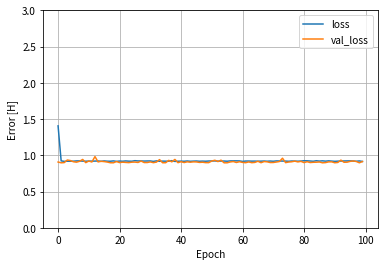

In [28]:
plot_loss(history)

Collect the results on the test set, for later:

In [29]:
test_results = {}

test_results['Vmsat_model'] = Vmsat_model.evaluate(
    test_features['Vmsat'],
    test_labels, verbose=0)

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [30]:
def plot_Vmsat(x, y):
  plt.scatter(train_features['Vmsat'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Vmsat')
  plt.ylabel('Vm')
  plt.legend()

In [31]:
x = tf.linspace(0.0, 15, 251)
y = Vmsat_model.predict(x)

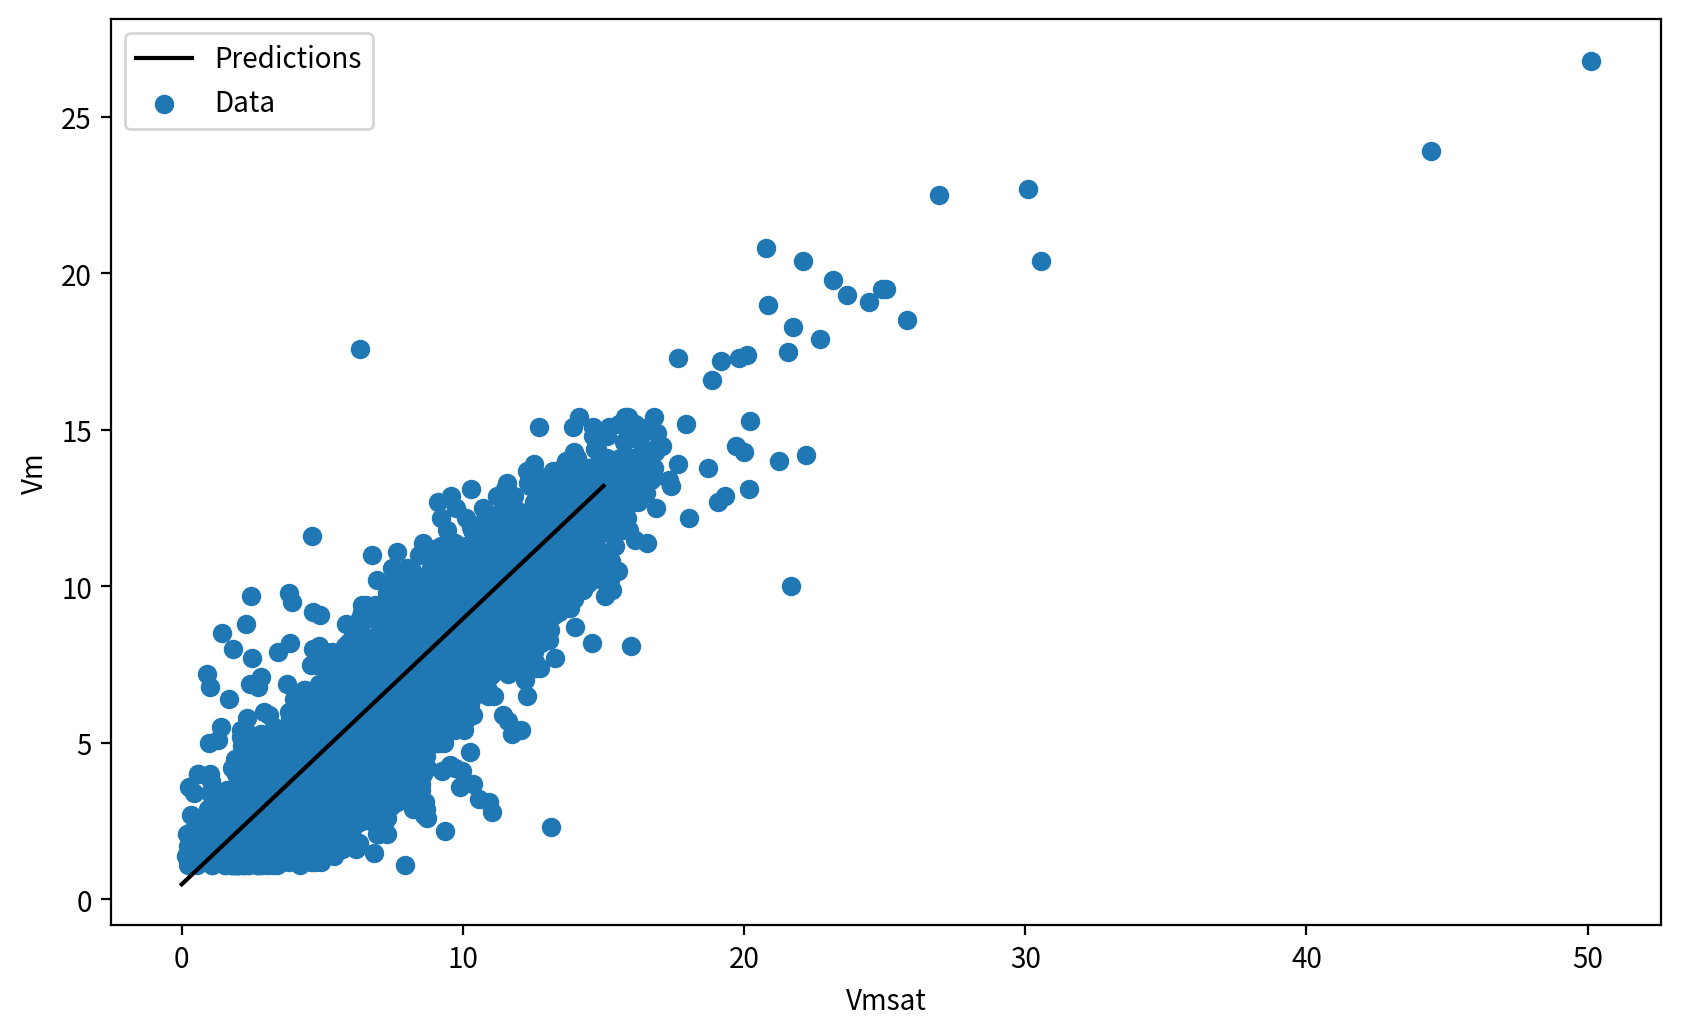

In [32]:
plt.figure(figsize=(10,6),dpi=200)
plot_Vmsat(x,y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [33]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [34]:
linear_model.predict(train_features[:10])

array([[-0.412],
       [-1.079],
       [ 0.525],
       [-0.017],
       [-1.088],
       [ 0.583],
       [-0.776],
       [-1.544],
       [-0.211],
       [ 0.495]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(4,1)`.

In [35]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.87 ],
       [-0.155],
       [-0.334],
       [-0.881]], dtype=float32)>

Use the same `compile` and `fit` calls as for the single input `Vmsat` model:

In [36]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [37]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 1min 37s, sys: 11min 54s, total: 13min 32s
Wall time: 23.1 s


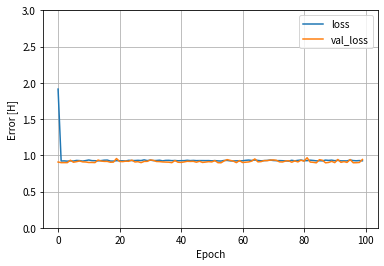

In [38]:
plot_loss(history)

In [39]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [40]:
pd.DataFrame(test_results, index=['Mean absolute error [Vm]']).T

,Mean absolute error [Vm]
Vmsat_model,0.933505
linear_model,0.944228


## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [41]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu', name="layer1"),
      layers.Dense(64, activation='relu', name="layer2"),
      layers.Dense(1, name="layer3")
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### One variable

Start with a DNN model for a single input: "Vmsat"

In [42]:
dnn_Vmsat_model = build_and_compile_model(Vmsat_normalizer)

This model has quite a few more trainable parameters than the linear models.

In [43]:
dnn_Vmsat_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
layer1 (Dense)               (None, 64)                128       
_________________________________________________________________
layer2 (Dense)               (None, 64)                4160      
_________________________________________________________________
layer3 (Dense)               (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model:

In [44]:
%%time
history = dnn_Vmsat_model.fit(
    train_features['Vmsat'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2min 42s, sys: 18min 33s, total: 21min 15s
Wall time: 36.1 s


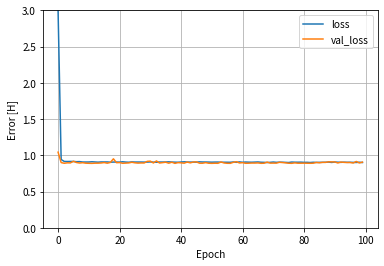

In [45]:
plot_loss(history)

In [46]:
x = tf.linspace(0.0, 15, 251)
y = dnn_Vmsat_model.predict(x)

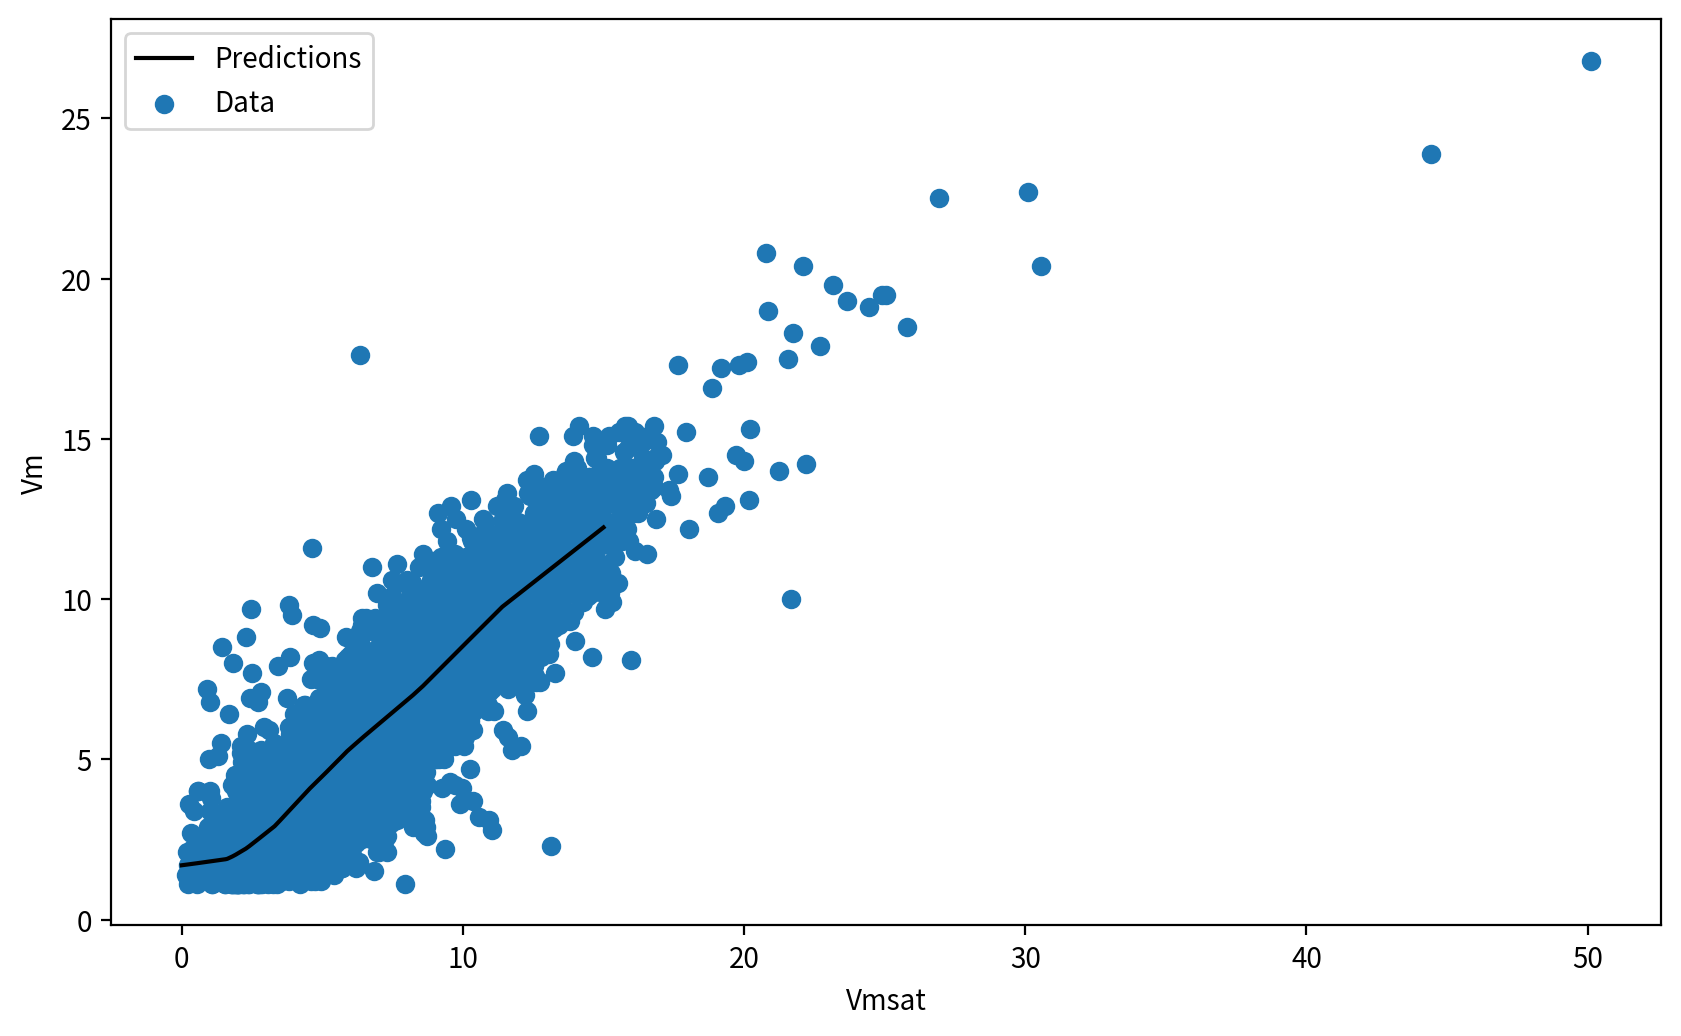

In [47]:
plt.figure(figsize=(10,6),dpi=200)
plot_Vmsat(x,y)

In [48]:
test_results['dnn_Vmsat_model'] = dnn_Vmsat_model.evaluate(
    test_features['Vmsat'], test_labels,
    verbose=0)

In [49]:
pd.DataFrame(test_results, index=['Mean absolute error [Vm]']).T

,Mean absolute error [Vm]
Vmsat_model,0.933505
linear_model,0.944228
dnn_Vmsat_model,0.925802


### Full model

If you repeat this process using all the inputs it slightly improves the performance on the validation dataset.

In [50]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
layer1 (Dense)               (None, 64)                320       
_________________________________________________________________
layer2 (Dense)               (None, 64)                4160      
_________________________________________________________________
layer3 (Dense)               (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [51]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2min 54s, sys: 19min 18s, total: 22min 12s
Wall time: 37.7 s


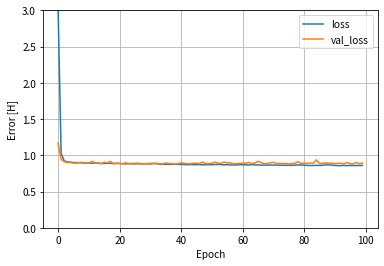

In [52]:
plot_loss(history)

In [53]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [54]:
pd.DataFrame(test_results, index=['Mean absolute error [Vm]']).T

,Mean absolute error [Vm]
Vmsat_model,0.933505
linear_model,0.944228
dnn_Vmsat_model,0.925802
dnn_model,0.907797


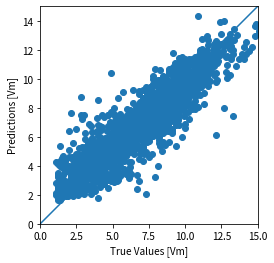

In [55]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Vm]')
plt.ylabel('Predictions [Vm]')
lims = [0, 15]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


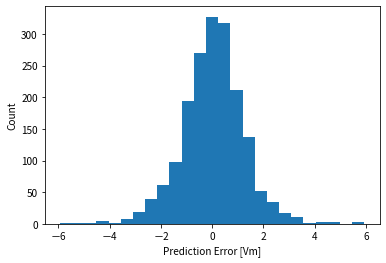

In [56]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Vm]')
_ = plt.ylabel('Count')

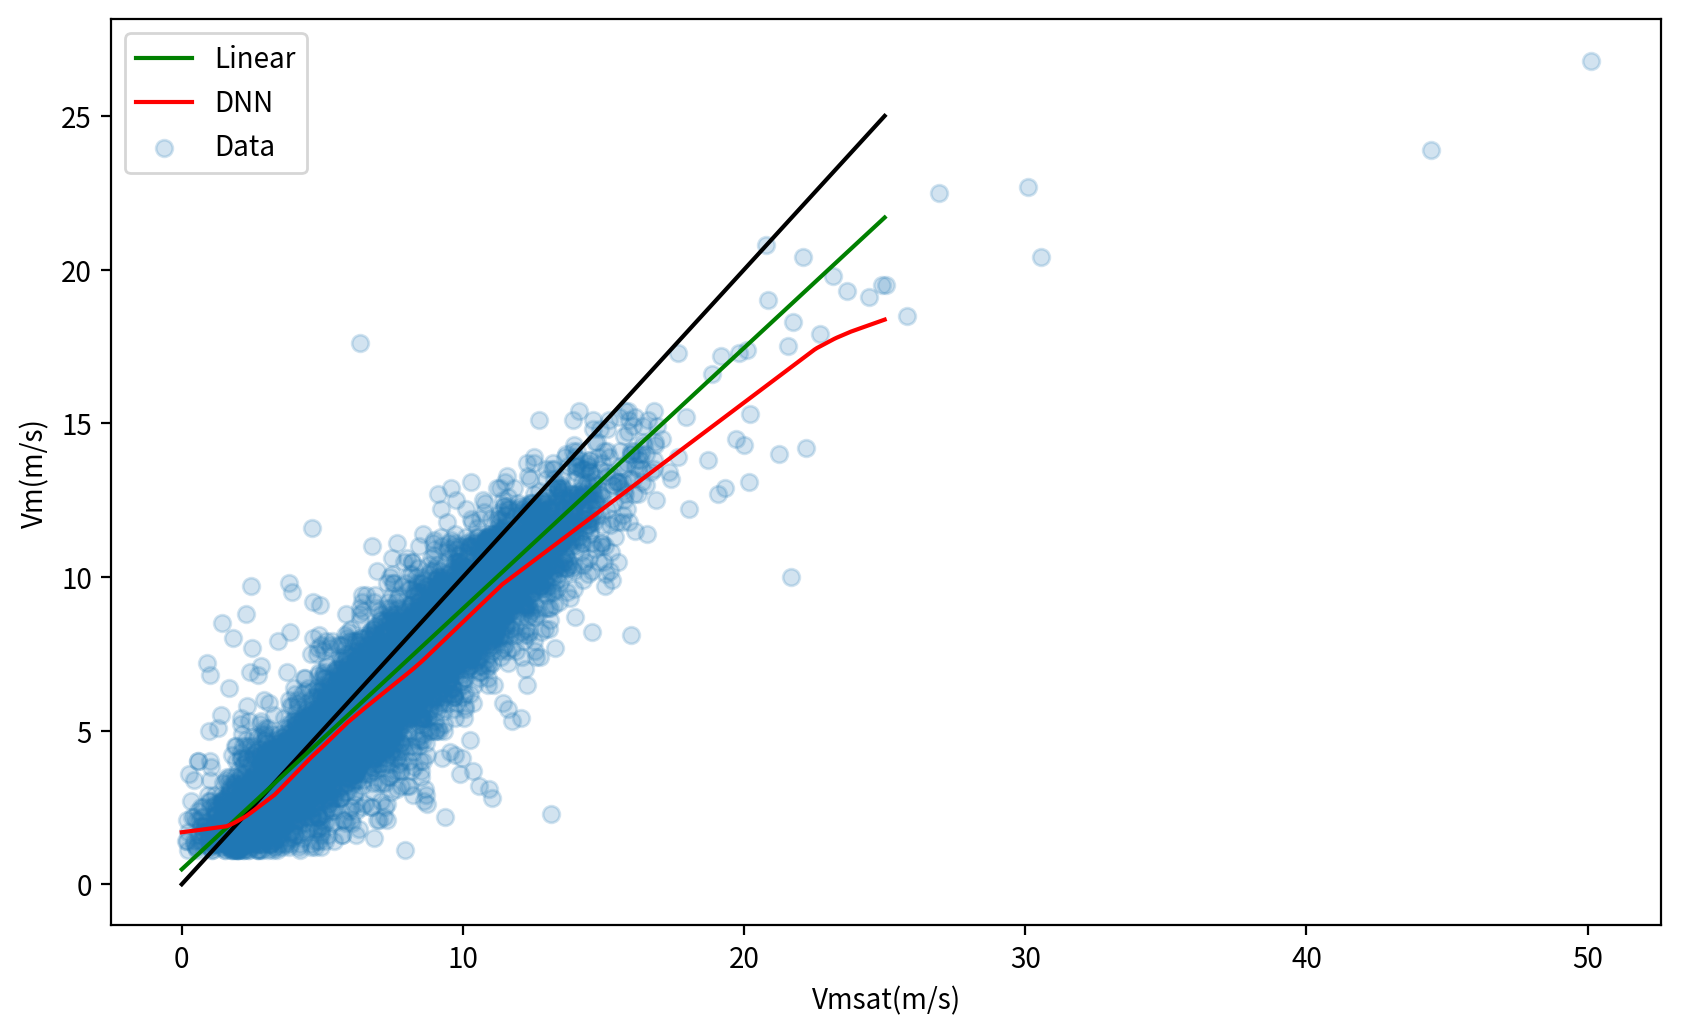

In [57]:
plt.figure(figsize=(10,6),dpi=200)
x = tf.linspace(0.0, 25, 251)
y1 = dnn_model.predict(pd.DataFrame(x))
y2 = dnn_Vmsat_model.predict(pd.DataFrame(x))
y4 = Vmsat_model.predict(pd.DataFrame(x))

plt.scatter(train_features['Vmsat'], train_labels, label='Data',alpha=0.2)
#plt.plot(x, y1, color='b', label='DNN_multi')
plt.plot(x, x, color='k')
plt.plot(x, y4, color='g', label='Linear')
plt.plot(x, y2, color='r', label='DNN')
plt.xlabel('Vmsat(m/s)')
plt.ylabel('Vm(m/s)')
plt.legend()

In [58]:
linear_model.save(   'saved_model/Vmsat_Vm_linear_model')
Vmsat_model.save(    'saved_model/Vmsat_Vm_Vmsat_model')
dnn_model.save(      'saved_model/Vmsat_Vm_ddn_model')
dnn_Vmsat_model.save('saved_model/Vmsat_Vm_ddn_Vmsat_model')

INFO:tensorflow:Assets written to: saved_model/Vmsat_Vm_linear_model/assets
INFO:tensorflow:Assets written to: saved_model/Vmsat_Vm_Vmsat_model/assets
INFO:tensorflow:Assets written to: saved_model/Vmsat_Vm_ddn_model/assets
INFO:tensorflow:Assets written to: saved_model/Vmsat_Vm_ddn_Vmsat_model/assets


# RNN

In [59]:
def build_and_compile_model_RNN(Norm):
  model = keras.Sequential([
      Norm,
      layers.SimpleRNN(64,  unroll=False, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [60]:
def build_and_compile_model_LSTM(Norm):
  model = keras.Sequential([
      Norm,
      layers.LSTM(64, input_shape=(1,1), activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [61]:
Vmsat_normalizer = preprocessing.Normalization(input_shape=[1,1], axis=None)
Vmsat_normalizer.adapt(Vmsat)

In [62]:
rnn_Vmsat_model = build_and_compile_model_RNN(Vmsat_normalizer)
#rnn_Vmsat_model = build_and_compile_model_LSTM(Vmsat_normalizer)

In [63]:
rnn_Vmsat_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 1, 1)              3         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                4224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,292
Trainable params: 4,289
Non-trainable params: 3
_________________________________________________________________


In [64]:
%%time
history = rnn_Vmsat_model.fit(
    train_features['Vmsat'], train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
182/182 [==============================] - 2s 5ms/step - loss: 6.0119 - val_loss: 3.8099
Epoch 2/100
182/182 [==============================] - 0s 2ms/step - loss: 2.6416 - val_loss: 0.9590
Epoch 3/100
182/182 [==============================] - 0s 2ms/step - loss: 0.9572 - val_loss: 0.8956
Epoch 4/100
182/182 [==============================] - 0s 2ms/step - loss: 0.9060 - val_loss: 0.8909
Epoch 5/100
182/182 [==============================] - 0s 2ms/step - loss: 0.9006 - val_loss: 0.8907
Epoch 6/100
182/182 [==============================] - 0s 2ms/step - loss: 0.9098 - val_loss: 0.8895
Epoch 7/100
182/182 [==============================] - 1s 3ms/step - loss: 0.9133 - val_loss: 0.8908
Epoch 8/100
182/182 [==============================] - 1s 3ms/step - loss: 0.9096 - val_loss: 0.8887
Epoch 9/100
182/182 [==============================] - 0s 3ms/step - loss: 0.8946 - val_loss: 0.8924
Epoch 10/100
182/182 [==============================] - 0s 2ms/step - loss: 0.8912 - val_lo

182/182 [==============================] - 1s 3ms/step - loss: 0.9252 - val_loss: 0.8917
Epoch 82/100
182/182 [==============================] - 0s 2ms/step - loss: 0.9051 - val_loss: 0.8966
Epoch 83/100
182/182 [==============================] - 0s 3ms/step - loss: 0.9223 - val_loss: 0.8973
Epoch 84/100
182/182 [==============================] - 0s 3ms/step - loss: 0.8957 - val_loss: 0.8893
Epoch 85/100
182/182 [==============================] - 0s 3ms/step - loss: 0.8965 - val_loss: 0.8926
Epoch 86/100
182/182 [==============================] - 0s 2ms/step - loss: 0.9074 - val_loss: 0.8940
Epoch 87/100
182/182 [==============================] - 0s 3ms/step - loss: 0.8865 - val_loss: 0.8891
Epoch 88/100
182/182 [==============================] - 0s 3ms/step - loss: 0.8968 - val_loss: 0.8929
Epoch 89/100
182/182 [==============================] - 0s 3ms/step - loss: 0.9037 - val_loss: 0.8899
Epoch 90/100
182/182 [==============================] - 0s 3ms/step - loss: 0.8951 - val_loss: 

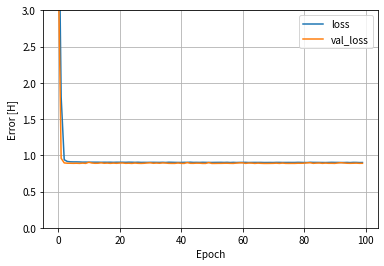

In [65]:
plot_loss(history)

In [66]:
test_results['rnn_Vmsat_model'] = rnn_Vmsat_model.evaluate(
    test_features['Vmsat'], test_labels,
    verbose=0)

In [67]:
pd.DataFrame(test_results, index=['Mean absolute error [Vm]']).T

,Mean absolute error [Vm]
Vmsat_model,0.933505
linear_model,0.944228
dnn_Vmsat_model,0.925802
dnn_model,0.907797
rnn_Vmsat_model,0.914302


### Multi-variable 

In [68]:
normalizer = preprocessing.Normalization(input_shape=[4,1], axis=None)
normalizer.adapt(np.array(train_features))

In [69]:
rnn_model = build_and_compile_model_RNN(normalizer)
rnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 4, 1)              3         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                4224      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,292
Trainable params: 4,289
Non-trainable params: 3
_________________________________________________________________


In [70]:
%%time
history = rnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
182/182 [==============================] - 2s 6ms/step - loss: 3.5982 - val_loss: 2.5519
Epoch 2/100
182/182 [==============================] - 1s 4ms/step - loss: 2.5128 - val_loss: 2.5496
Epoch 3/100
182/182 [==============================] - 1s 5ms/step - loss: 2.5388 - val_loss: 2.5834
Epoch 4/100
182/182 [==============================] - 1s 5ms/step - loss: 2.4951 - val_loss: 2.5610
Epoch 5/100
182/182 [==============================] - 1s 5ms/step - loss: 2.4425 - val_loss: 2.5452
Epoch 6/100
182/182 [==============================] - 1s 4ms/step - loss: 2.4881 - val_loss: 2.5377
Epoch 7/100
182/182 [==============================] - 1s 5ms/step - loss: 2.4979 - val_loss: 2.5359
Epoch 8/100
182/182 [==============================] - 1s 5ms/step - loss: 2.4958 - val_loss: 2.5531
Epoch 9/100
182/182 [==============================] - 1s 6ms/step - loss: 2.4720 - val_loss: 2.5852
Epoch 10/100
182/182 [==============================] - 1s 6ms/step - loss: 2.5639 - val_lo

182/182 [==============================] - 1s 4ms/step - loss: 1.8485 - val_loss: 1.7853
Epoch 82/100
182/182 [==============================] - 1s 4ms/step - loss: 1.8817 - val_loss: 1.9469
Epoch 83/100
182/182 [==============================] - 1s 4ms/step - loss: 1.9911 - val_loss: 1.7496
Epoch 84/100
182/182 [==============================] - 1s 4ms/step - loss: 1.9101 - val_loss: 1.8518
Epoch 85/100
182/182 [==============================] - 1s 4ms/step - loss: 1.8419 - val_loss: 1.9778
Epoch 86/100
182/182 [==============================] - 1s 5ms/step - loss: 1.8122 - val_loss: 1.8617
Epoch 87/100
182/182 [==============================] - 1s 5ms/step - loss: 1.8671 - val_loss: 1.7706
Epoch 88/100
182/182 [==============================] - 1s 5ms/step - loss: 1.8400 - val_loss: 1.7368
Epoch 89/100
182/182 [==============================] - 1s 5ms/step - loss: 1.8358 - val_loss: 2.0509
Epoch 90/100
182/182 [==============================] - 1s 5ms/step - loss: 1.8597 - val_loss: 

In [71]:
test_results['rnn_model'] = rnn_model.evaluate(
    test_features, test_labels,
    verbose=0)

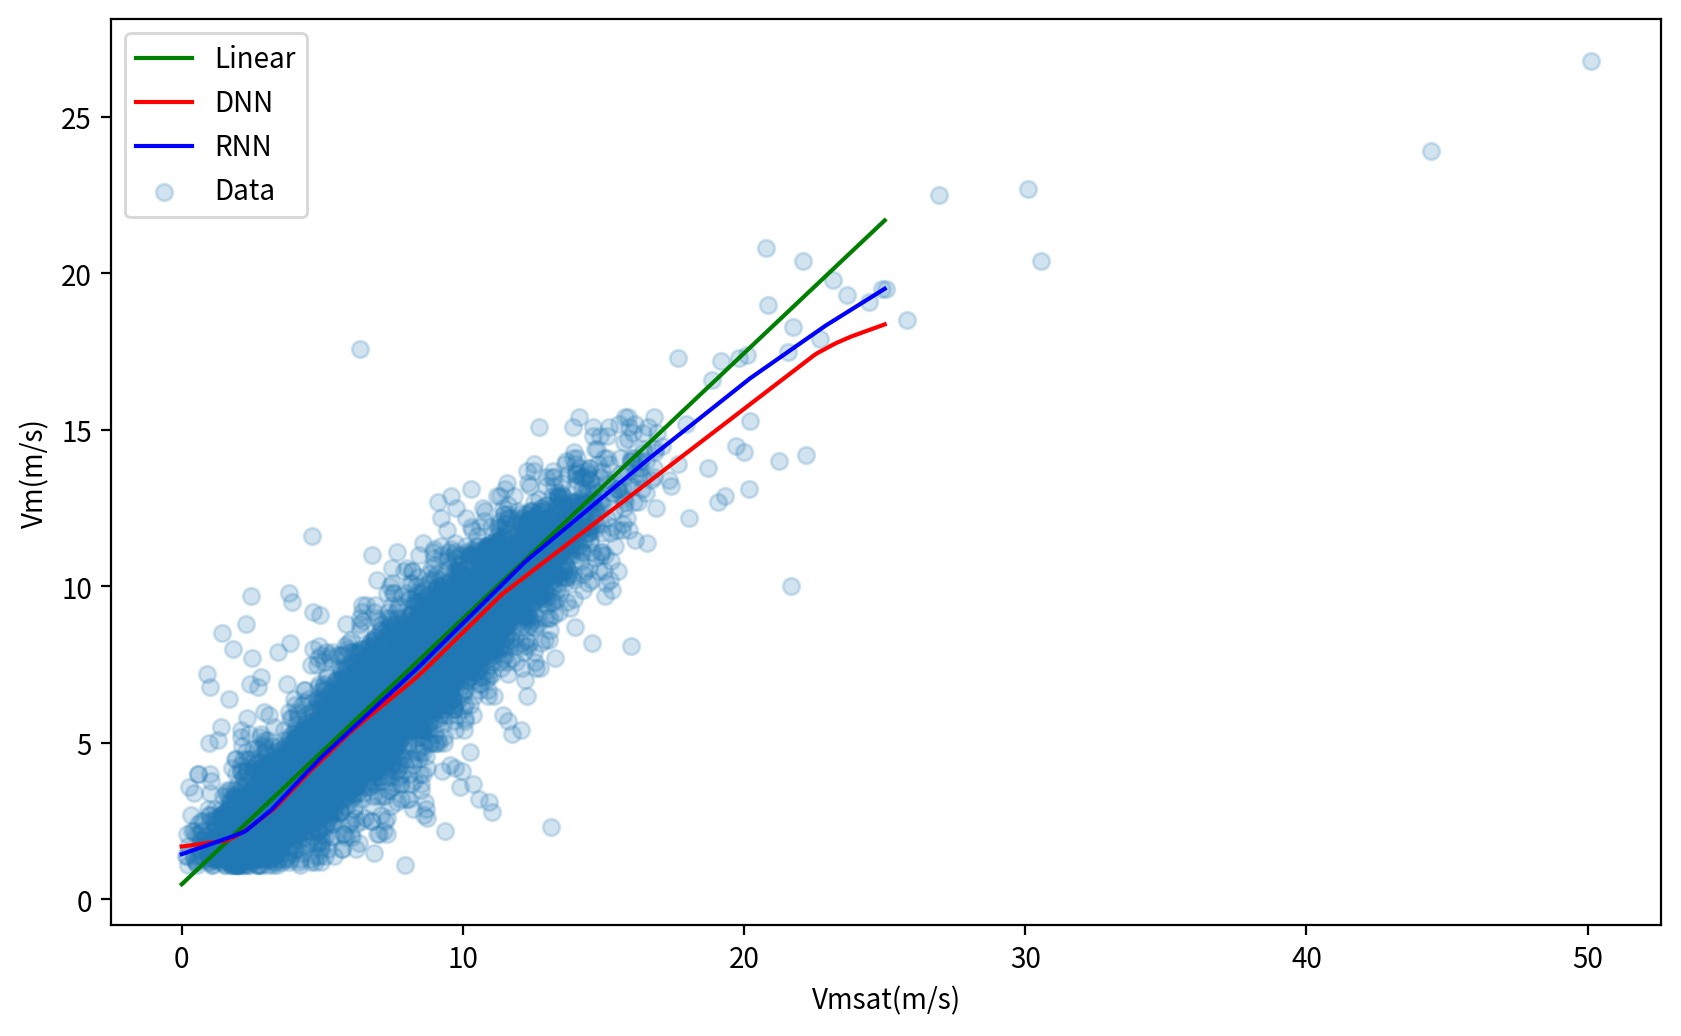

In [72]:
plt.figure(figsize=(10,6),dpi=200)
x = tf.linspace(0.0, 25, 251)
y1 = rnn_Vmsat_model.predict(x)
y2 = dnn_Vmsat_model.predict(x)
y4 = Vmsat_model.predict(x)

plt.scatter(train_features['Vmsat'], train_labels, label='Data',alpha=0.2)
#plt.plot(x, y1, color='b', label='DNN_multi')
#plt.plot(x, x, color='k')
plt.plot(x, y4, color='g', label='Linear')
plt.plot(x, y2, color='r', label='DNN')
plt.plot(x, y1, color='b', label='RNN')
plt.xlabel('Vmsat(m/s)')
plt.ylabel('Vm(m/s)')
plt.legend()

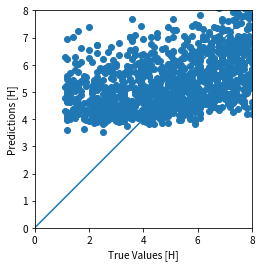

In [73]:
test_predictions = rnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

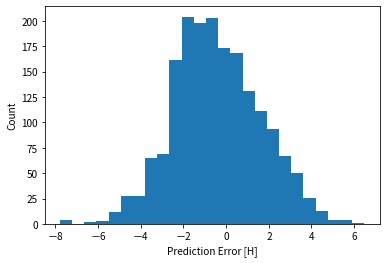

In [74]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
_ = plt.ylabel('Count')

In [75]:
rnn_model.save(   'saved_model/Vmsat_Vm_rnn_model')
rnn_Vmsat_model.save('saved_model/Vmsat_Vm_rnn_Vmsat_model')

INFO:tensorflow:Assets written to: saved_model/Vmsat_Vm_rnn_model/assets
INFO:tensorflow:Assets written to: saved_model/Vmsat_Vm_rnn_Vmsat_model/assets


# SVM

In [76]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

In [77]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1),
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

In [78]:
history = svr.fit(np.array(train_features['Vmsat']).reshape(-1,1), train_labels)

In [79]:
train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    svr,
    np.array(test_features['Vmsat']).reshape(-1,1),
    test_labels,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_absolute_error",
    cv=10,
)

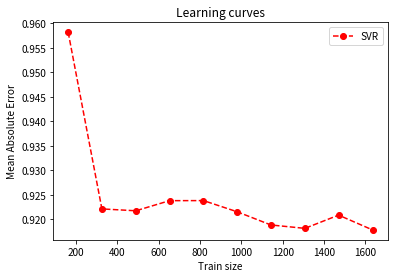

In [80]:
#plt.plot(train_sizes, -test_scores_kr.mean(1), "o--", color="g", label="KRR")
plt.plot(train_sizes, -test_scores_svr.mean(1), "o--", color="r", label="SVR")
plt.xlabel("Train size")
plt.ylabel("Mean Absolute Error")
plt.title("Learning curves")
plt.legend(loc="best")

In [81]:
svr.predict(np.array(train_features['Vmsat']).reshape(-1,1))

array([ 6.519,  8.721,  2.531, ...,  4.826,  3.65 , 10.589])

In [82]:
import joblib
joblib.dump(svr, 'saved_model/Vmsat_Vm_svr_Vm_model')

['saved_model/Vmsat_Vm_svr_Vm_model']

In [83]:
svr2 = joblib.load("saved_model/Vmsat_Vm_svr_Vm_model")

In [84]:
svr2.predict(np.array(train_features['Vmsat']).reshape(-1,1))

array([ 6.519,  8.721,  2.531, ...,  4.826,  3.65 , 10.589])

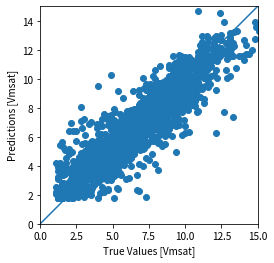

In [85]:
test_predictions = svr2.predict(np.asarray(test_features['Vmsat'])[:,None]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Vmsat]')
plt.ylabel('Predictions [Vmsat]')
lims = [0, 15]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

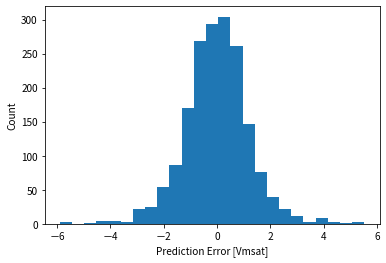

In [86]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Vmsat]')
_ = plt.ylabel('Count')

## Multi-variable

In [87]:
history = svr.fit(np.array(train_features), train_labels)

In [88]:
train_sizes_mv, train_scores_svr_mv, test_scores_svr_mv = learning_curve(
    svr,
    np.array(test_features),
    test_labels,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_absolute_error",
    cv=10,
)

In [89]:
import joblib
joblib.dump(svr, 'saved_model/Vmsat_Vm_svr_model')

['saved_model/Vmsat_Vm_svr_model']

In [90]:
svr = joblib.load("saved_model/Vmsat_Vm_svr_model")

In [91]:
svr.predict(np.array(train_features))

array([ 6.486,  9.097,  2.391, ...,  4.942,  3.604, 10.532])

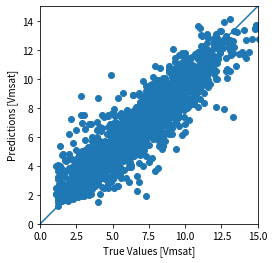

In [92]:
test_predictions = svr.predict(np.asarray(test_features)).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Vmsat]')
plt.ylabel('Predictions [Vmsat]')
lims = [0, 15]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

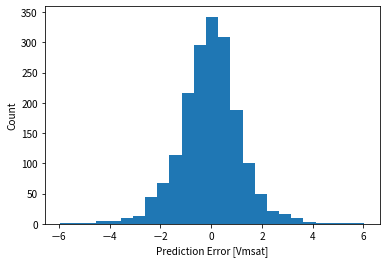

In [93]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Vmsat]')
_ = plt.ylabel('Count')